# Phase 1.5: Subsampling Strategy Development and Testing

The dataset is large and contains many rows where `is_trading = 0` (non-trading periods). Training on the full dataset is:
1. Computationally expensive
2. Potentially inefficient (non-trading data has weak signal)

This notebook develops and tests different subsampling strategies:
1. **Trading-Only**: Use only trading periods
2. **Stratified**: Keep all trading + small fraction of non-trading
3. **Boundary-Aware**: Keep trading + periods around trading boundaries
4. **Hybrid**: Combination approach

We will test these strategies with a simple LSTM model to measure:
- Training speed
- Convergence quality
- Validation performance

The best strategy will be used for Chronos training (Phase 3).

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import time
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from darts import TimeSeries
from darts.models import BlockRNNModel
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
if os.path.basename(os.getcwd()) == 'notebooks':
    project_root = os.path.abspath('..')
else:
    project_root = os.getcwd()

if project_root not in sys.path:
    sys.path.append(project_root)

from src.datamodule import masked_smoothed_smape

# Set precision
torch.backends.fp32_precision = "medium"
torch.backends.cuda.matmul.fp32_precision = "medium"
torch.backends.cudnn.fp32_precision = "medium"
torch.backends.cudnn.conv.fp32_precision = "tf32"
torch.backends.cudnn.rnn.fp32_precision = "tf32"

# Set style
sns.set_style('whitegrid')
%matplotlib inline

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


## 1. Setup and Data Loading

In [2]:
# Define paths
BASE_DIR = ".."
DATA_DIR = os.path.join(BASE_DIR, "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(RESULTS_DIR, exist_ok=True)

# Configuration
INPUT_CHUNK_LENGTH = 24
OUTPUT_CHUNK_LENGTH = 10
TARGET_COLS = ["high", "low", "close", "volume"]
SEED = 827

# Select a few representative assets for testing
TEST_ASSETS = 3  # Number of assets to test with

print(f"Configuration:")
print(f"  Input chunk length: {INPUT_CHUNK_LENGTH}")
print(f"  Output chunk length: {OUTPUT_CHUNK_LENGTH}")
print(f"  Test assets: {TEST_ASSETS}")
print(f"  Seed: {SEED}")

Configuration:
  Input chunk length: 24
  Output chunk length: 10
  Test assets: 3
  Seed: 827


## 2. Analyze Trading vs Non-Trading Distribution

TRADING DISTRIBUTION ANALYSIS
  asset  total_rows  trading_rows  non_trading_rows  trading_pct
Fri00Q1       69517          3309             66208     4.759987
Fri00Q2       69517          3371             66146     4.849174
Fri00Q3       69517          3429             66088     4.932606
Fri00Q4       69517          3494             66023     5.026109
Fri01Q1       69517          3666             65851     5.273530
Fri01Q2       69517          3724             65793     5.356963
Fri01Q3       69517          3831             65686     5.510882
Fri01Q4       69517          3905             65612     5.617331
Fri02Q1       69517          3988             65529     5.736726
Fri02Q2       69517          4046             65471     5.820159
Fri02Q3       69517          4149             65368     5.968324
Fri02Q4       69517          4271             65246     6.143821
Fri03Q1       69517          4324             65193     6.220061
Fri03Q2       69517          4434             65083     6.37

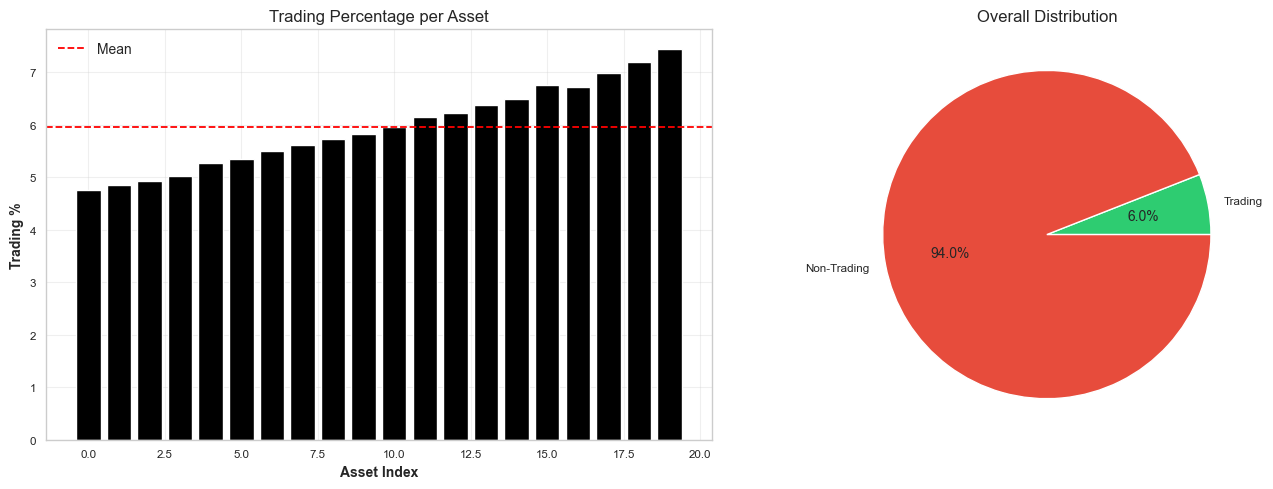

In [3]:
def analyze_trading_distribution(data_dir, max_assets=10):
    """
    Analyze the distribution of trading vs non-trading periods.
    """
    files = sorted([f for f in os.listdir(data_dir) if f.endswith('.parquet')])[:max_assets]
    
    stats = []
    
    for file in files:
        df = pd.read_parquet(os.path.join(data_dir, file))
        asset_name = file.replace('.parquet', '')
        
        total_rows = len(df)
        trading_rows = (df['is_trading'] == 1).sum()
        non_trading_rows = total_rows - trading_rows
        trading_pct = 100 * trading_rows / total_rows
        
        stats.append({
            'asset': asset_name,
            'total_rows': total_rows,
            'trading_rows': trading_rows,
            'non_trading_rows': non_trading_rows,
            'trading_pct': trading_pct
        })
    
    return pd.DataFrame(stats)


print("="*80)
print("TRADING DISTRIBUTION ANALYSIS")
print("="*80)

stats_df = analyze_trading_distribution(TRAIN_DIR, max_assets=20)
print(stats_df.to_string(index=False))

print("\nSummary Statistics:")
print(f"  Average trading %: {stats_df['trading_pct'].mean():.2f}%")
print(f"  Min trading %: {stats_df['trading_pct'].min():.2f}%")
print(f"  Max trading %: {stats_df['trading_pct'].max():.2f}%")
print(f"  Total rows: {stats_df['total_rows'].sum():,}")
print(f"  Total trading rows: {stats_df['trading_rows'].sum():,}")
print(f"  Total non-trading rows: {stats_df['non_trading_rows'].sum():,}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of trading percentages
axes[0].bar(range(len(stats_df)), stats_df['trading_pct'])
axes[0].set_xlabel('Asset Index')
axes[0].set_ylabel('Trading %')
axes[0].set_title('Trading Percentage per Asset')
axes[0].axhline(y=stats_df['trading_pct'].mean(), color='r', linestyle='--', label='Mean')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pie chart of overall distribution
total_trading = stats_df['trading_rows'].sum()
total_non_trading = stats_df['non_trading_rows'].sum()
axes[1].pie([total_trading, total_non_trading], 
            labels=['Trading', 'Non-Trading'],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Overall Distribution')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'trading_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)

## 3. Define Subsampling Strategies

In [4]:
def strategy_trading_only(df):
    """
    Strategy 1: Keep only trading periods.
    
    Pros: Maximum signal, smallest dataset
    Cons: Loses context of non-trading periods
    """
    return df[df['is_trading'] == 1].copy()


def strategy_stratified(df, non_trading_fraction=0.1):
    """
    Strategy 2: Keep all trading + fraction of non-trading.
    
    Pros: Maintains some non-trading context
    Cons: May include redundant non-trading data
    """
    trading_df = df[df['is_trading'] == 1].copy()
    non_trading_df = df[df['is_trading'] == 0].copy()
    
    # Sample non-trading rows
    n_sample = int(len(non_trading_df) * non_trading_fraction)
    non_trading_sample = non_trading_df.sample(n=n_sample, random_state=SEED)
    
    # Combine and sort by time
    combined = pd.concat([trading_df, non_trading_sample])
    combined = combined.sort_values('ExecutionTime').reset_index(drop=True)
    
    return combined


def strategy_boundary_aware(df, window_before=4, window_after=4):
    """
    Strategy 3: Keep trading + periods around trading boundaries.
    
    Pros: Preserves transition context
    Cons: More complex, may still include too much data
    """
    df = df.copy()
    df['keep'] = False
    
    # Keep all trading rows
    df.loc[df['is_trading'] == 1, 'keep'] = True
    
    # Find boundaries (trading starts and stops)
    trading = df['is_trading'].values
    changes = np.diff(trading, prepend=0)
    
    # Indices where trading starts (0 -> 1)
    starts = np.where(changes == 1)[0]
    # Indices where trading stops (1 -> 0)
    stops = np.where(changes == -1)[0]
    
    # Mark rows around boundaries
    for start in starts:
        begin = max(0, start - window_before)
        df.loc[begin:start, 'keep'] = True
    
    for stop in stops:
        end = min(len(df), stop + window_after)
        df.loc[stop:end, 'keep'] = True
    
    return df[df['keep']].drop(columns=['keep'])


def strategy_hybrid(df, non_trading_fraction=0.05, window_before=4, window_after=4):
    """
    Strategy 4: Combination of boundary-aware + stratified sampling.
    
    Pros: Balances context and efficiency
    Cons: Most complex
    """
    # Start with boundary-aware
    df_boundary = strategy_boundary_aware(df, window_before, window_after)
    
    # Find remaining non-trading rows
    kept_indices = set(df_boundary.index)
    non_trading_df = df[(df['is_trading'] == 0) & (~df.index.isin(kept_indices))].copy()
    
    # Sample additional non-trading rows
    if len(non_trading_df) > 0:
        n_sample = int(len(non_trading_df) * non_trading_fraction)
        if n_sample > 0:
            non_trading_sample = non_trading_df.sample(n=n_sample, random_state=SEED)
            
            # Combine
            combined = pd.concat([df_boundary, non_trading_sample])
            combined = combined.sort_values('ExecutionTime').reset_index(drop=True)
            return combined
    
    return df_boundary


print("Defined 4 subsampling strategies:")
print("  1. Trading-Only")
print("  2. Stratified (10% non-trading)")
print("  3. Boundary-Aware (±4 rows around transitions)")
print("  4. Hybrid (boundary + 5% non-trading)")

Defined 4 subsampling strategies:
  1. Trading-Only
  2. Stratified (10% non-trading)
  3. Boundary-Aware (±4 rows around transitions)
  4. Hybrid (boundary + 5% non-trading)


## 4. Compare Strategy Statistics

STRATEGY COMPARISON ON: Fri00Q1.parquet
        Strategy  Total Rows  Trading  Non-Trading  Trading %  Size Reduction %
        Original       69517     3309        66208   4.759987          0.000000
    Trading-Only        3309     3309            0 100.000000         95.240013
Stratified (10%)        9929     3309         6620  33.326619         85.717163
  Boundary-Aware        4245     3309          936  77.950530         93.893580
          Hybrid        7508     3309         4199  44.072989         89.199764


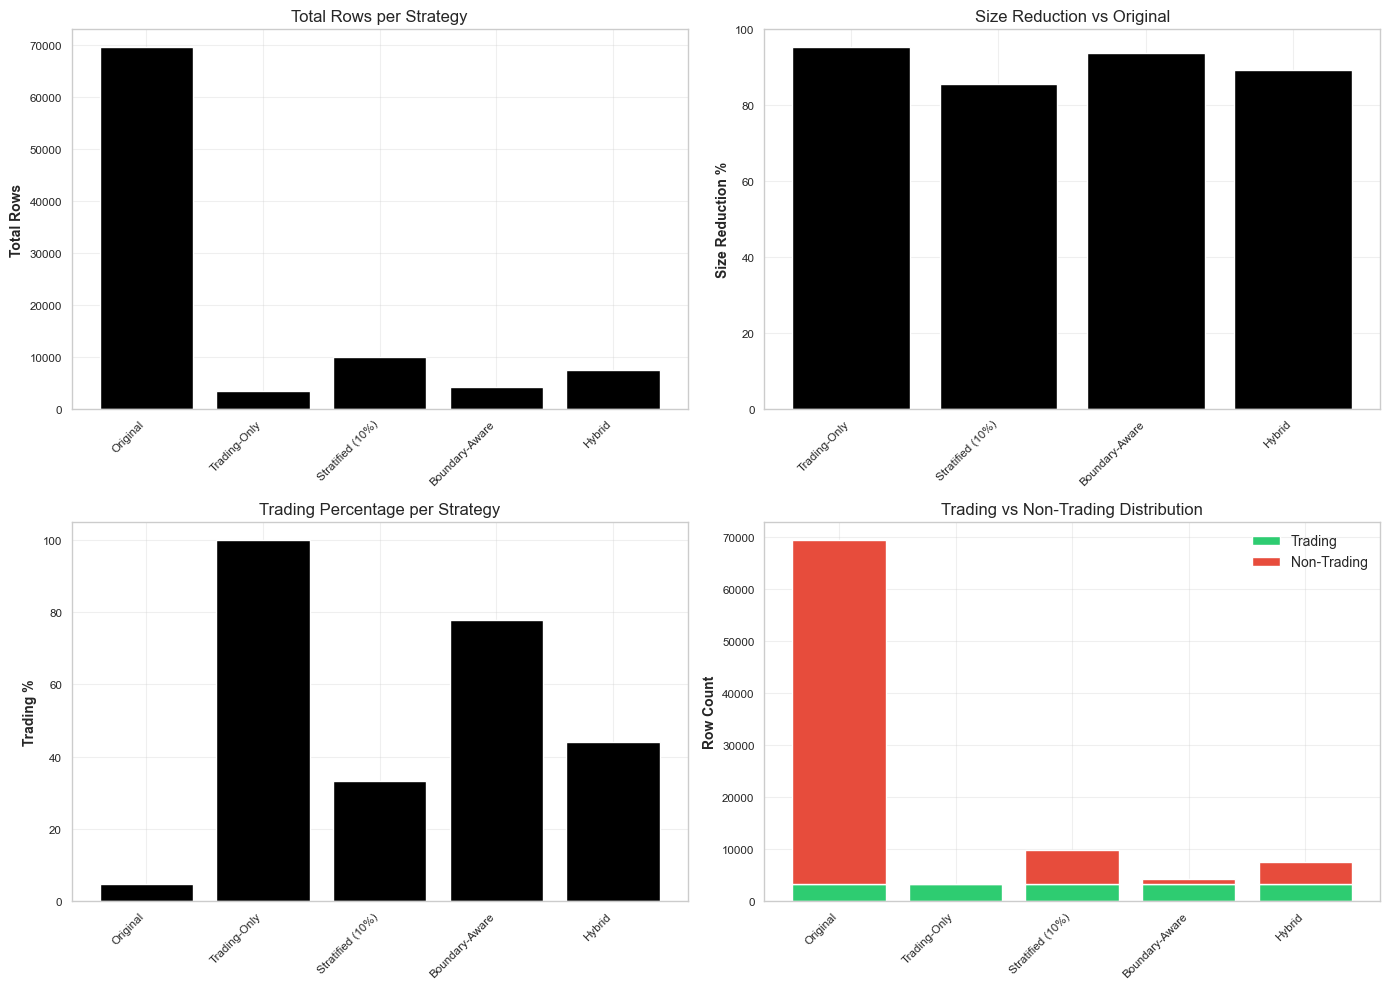

In [5]:
def compare_strategies(data_path):
    """
    Compare the output of different strategies on a single asset.
    """
    df = pd.read_parquet(data_path)
    
    strategies = {
        'Original': df,
        'Trading-Only': strategy_trading_only(df),
        'Stratified (10%)': strategy_stratified(df, 0.1),
        'Boundary-Aware': strategy_boundary_aware(df, 4, 4),
        'Hybrid': strategy_hybrid(df, 0.05, 4, 4)
    }
    
    results = []
    for name, data in strategies.items():
        total = len(data)
        trading = (data['is_trading'] == 1).sum()
        non_trading = total - trading
        
        results.append({
            'Strategy': name,
            'Total Rows': total,
            'Trading': trading,
            'Non-Trading': non_trading,
            'Trading %': 100 * trading / total,
            'Size Reduction %': 100 * (1 - total / len(df))
        })
    
    return pd.DataFrame(results), strategies


# Test on first asset
test_file = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith('.parquet')])[0]
test_path = os.path.join(TRAIN_DIR, test_file)

print("="*80)
print(f"STRATEGY COMPARISON ON: {test_file}")
print("="*80)

comparison_df, strategy_data = compare_strategies(test_path)
print(comparison_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. Total rows comparison
axes[0].bar(range(len(comparison_df)), comparison_df['Total Rows'])
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
axes[0].set_ylabel('Total Rows')
axes[0].set_title('Total Rows per Strategy')
axes[0].grid(True, alpha=0.3)

# 2. Size reduction
axes[1].bar(range(1, len(comparison_df)), comparison_df['Size Reduction %'].iloc[1:])
axes[1].set_xticks(range(1, len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Strategy'].iloc[1:], rotation=45, ha='right')
axes[1].set_ylabel('Size Reduction %')
axes[1].set_title('Size Reduction vs Original')
axes[1].grid(True, alpha=0.3)

# 3. Trading percentage
axes[2].bar(range(len(comparison_df)), comparison_df['Trading %'])
axes[2].set_xticks(range(len(comparison_df)))
axes[2].set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
axes[2].set_ylabel('Trading %')
axes[2].set_title('Trading Percentage per Strategy')
axes[2].grid(True, alpha=0.3)

# 4. Stacked bar of trading vs non-trading
trading = comparison_df['Trading'].values
non_trading = comparison_df['Non-Trading'].values
x = range(len(comparison_df))
axes[3].bar(x, trading, label='Trading', color='#2ecc71')
axes[3].bar(x, non_trading, bottom=trading, label='Non-Trading', color='#e74c3c')
axes[3].set_xticks(x)
axes[3].set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
axes[3].set_ylabel('Row Count')
axes[3].set_title('Trading vs Non-Trading Distribution')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'strategy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)

## 5. Test Strategies with LSTM Training

Train a simple LSTM model with each strategy to measure:
- Training time
- Convergence speed
- Validation performance

In [6]:
def prepare_timeseries_for_strategy(strategy_name, strategy_func, train_files, val_dir, target_cols, input_chunk_length):
    """
    Prepare TimeSeries data using a specific strategy.
    """
    train_ts_list = []
    val_ts_list = []
    past_cov_train_list = []
    past_cov_val_list = []
    
    for train_file in train_files:
        asset_name = train_file.replace('.parquet', '')
        train_path = os.path.join(TRAIN_DIR, train_file)
        val_path = os.path.join(val_dir, train_file)
        
        if not os.path.exists(val_path):
            continue
        
        # Load and apply strategy
        train_df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path)
        
        # Apply strategy
        if strategy_name == 'Original':
            train_df_sampled = train_df
            val_df_sampled = val_df
        elif strategy_name == 'Trading-Only':
            train_df_sampled = strategy_trading_only(train_df)
            val_df_sampled = strategy_trading_only(val_df)
        elif strategy_name == 'Stratified':
            train_df_sampled = strategy_stratified(train_df, 0.1)
            val_df_sampled = strategy_stratified(val_df, 0.1)
        elif strategy_name == 'Boundary-Aware':
            train_df_sampled = strategy_boundary_aware(train_df, 4, 4)
            val_df_sampled = strategy_boundary_aware(val_df, 4, 4)
        elif strategy_name == 'Hybrid':
            train_df_sampled = strategy_hybrid(train_df, 0.05, 4, 4)
            val_df_sampled = strategy_hybrid(val_df, 0.05, 4, 4)
        else:
            raise ValueError(f"Unknown strategy: {strategy_name}")
        
        # Check minimum length
        min_length = input_chunk_length + OUTPUT_CHUNK_LENGTH + 10
        if len(train_df_sampled) < min_length or len(val_df_sampled) < min_length:
            continue
        
        # Clean timestamps
        train_df_sampled['ExecutionTime'] = pd.to_datetime(train_df_sampled['ExecutionTime']).dt.tz_localize(None)
        val_df_sampled['ExecutionTime'] = pd.to_datetime(val_df_sampled['ExecutionTime']).dt.tz_localize(None)
        
        # Clean numeric data
        numeric_cols = train_df_sampled.select_dtypes(include=[np.number]).columns
        for df in [train_df_sampled, val_df_sampled]:
            df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
            df[numeric_cols] = df[numeric_cols].ffill().bfill().fillna(0)
            df[numeric_cols] = df[numeric_cols].astype(np.float32)
        
        # Create continuous time index
        train_df_sampled = train_df_sampled.reset_index(drop=True)
        val_df_sampled = val_df_sampled.reset_index(drop=True)
        
        train_df_sampled['ExecutionTime'] = pd.date_range(
            start='2020-01-01', periods=len(train_df_sampled), freq='15min'
        )
        val_df_sampled['ExecutionTime'] = pd.date_range(
            start='2021-01-01', periods=len(val_df_sampled), freq='15min'
        )
        
        # Get covariate columns
        covariate_cols = [
            col for col in train_df_sampled.columns 
            if col not in target_cols + ['ExecutionTime', 'is_trading']
        ]
        
        try:
            # Create TimeSeries
            train_ts = TimeSeries.from_dataframe(
                train_df_sampled, time_col='ExecutionTime', value_cols=target_cols, freq='15min'
            )
            val_ts = TimeSeries.from_dataframe(
                val_df_sampled, time_col='ExecutionTime', value_cols=target_cols, freq='15min'
            )
            
            train_ts_list.append(train_ts)
            val_ts_list.append(val_ts)
            
            # Create covariates
            if len(covariate_cols) > 0:
                past_cov_train = TimeSeries.from_dataframe(
                    train_df_sampled, time_col='ExecutionTime', value_cols=covariate_cols, freq='15min'
                )
                past_cov_val = TimeSeries.from_dataframe(
                    val_df_sampled, time_col='ExecutionTime', value_cols=covariate_cols, freq='15min'
                )
                past_cov_train_list.append(past_cov_train)
                past_cov_val_list.append(past_cov_val)
            else:
                past_cov_train_list.append(None)
                past_cov_val_list.append(None)
        
        except Exception as e:
            print(f"  Error with {asset_name}: {e}")
            continue
    
    return train_ts_list, val_ts_list, past_cov_train_list, past_cov_val_list


def train_lstm_with_strategy(strategy_name, train_ts_list, val_ts_list, past_cov_train, past_cov_val, max_time_minutes=15):
    """
    Train a simple LSTM model with a given strategy.
    """
    print(f"\n{'='*60}")
    print(f"Training with {strategy_name}")
    print(f"{'='*60}")
    print(f"  Assets: {len(train_ts_list)}")
    print(f"  Max time: {max_time_minutes} minutes")
    
    # Simple LSTM configuration
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        verbose=False
    )
    
    trainer_kwargs = {
        'accelerator': 'gpu',
        'devices': 1,
        'precision': '16-mixed',
        'max_epochs': 20,
        'gradient_clip_val': 1.0,
        'enable_progress_bar': False,
        'enable_model_summary': False,
        'logger': False,
        'callbacks': [early_stopping],
        'benchmark': True
    }
    
    model = BlockRNNModel(
        model="LSTM",
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        hidden_dim=64,
        n_rnn_layers=2,
        dropout=0.1,
        batch_size=64,
        n_epochs=20,
        loss_fn=torch.nn.L1Loss(),
        optimizer_kwargs={'lr': 0.001},
        model_name=f"LSTM_{strategy_name}",
        force_reset=True,
        random_state=SEED,
        pl_trainer_kwargs=trainer_kwargs
    )
    
    start_time = time.time()
    
    try:
        model.fit(
            series=train_ts_list,
            past_covariates=past_cov_train,
            val_series=val_ts_list,
            val_past_covariates=past_cov_val,
            verbose=False
        )
        
        training_time = time.time() - start_time
        
        # Get validation loss
        if hasattr(model, 'trainer') and model.trainer is not None:
            val_loss = model.trainer.callback_metrics.get("val_loss", None)
            if val_loss is not None:
                val_loss_value = float(val_loss.item() if torch.is_tensor(val_loss) else val_loss)
            else:
                val_loss_value = np.inf
            
            epochs_trained = model.trainer.current_epoch + 1
        else:
            val_loss_value = np.inf
            epochs_trained = 0
        
        print(f"  ✓ Training completed:")
        print(f"    Time: {training_time/60:.2f} minutes")
        print(f"    Epochs: {epochs_trained}")
        print(f"    Val Loss: {val_loss_value:.4f}")
        
        return {
            'strategy': strategy_name,
            'training_time_minutes': training_time / 60,
            'epochs_trained': epochs_trained,
            'val_loss': val_loss_value,
            'converged': epochs_trained < 20,  # Didn't hit max epochs
            'success': True
        }
    
    except Exception as e:
        print(f"  ✗ Training failed: {e}")
        training_time = time.time() - start_time
        
        return {
            'strategy': strategy_name,
            'training_time_minutes': training_time / 60,
            'epochs_trained': 0,
            'val_loss': np.inf,
            'converged': False,
            'success': False
        }
    
    finally:
        if 'model' in locals():
            del model
        torch.cuda.empty_cache()


print("Starting strategy evaluation with LSTM training...\n")

Starting strategy evaluation with LSTM training...



## 6. Run Experiments

In [7]:
torch.set_float32_matmul_precision('medium')

# Select test assets
test_files = sorted([f for f in os.listdir(TRAIN_DIR) if f.endswith('.parquet')])[:TEST_ASSETS]

print(f"Testing {len(test_files)} assets:")
for f in test_files:
    print(f"  - {f}")

# Test each strategy
strategies_to_test = ['Trading-Only', 'Stratified', 'Boundary-Aware', 'Hybrid']
results = []

for strategy_name in strategies_to_test:
    print(f"\n{'='*80}")
    print(f"TESTING STRATEGY: {strategy_name}")
    print(f"{'='*80}")
    
    # Prepare data
    train_ts, val_ts, past_cov_train, past_cov_val = prepare_timeseries_for_strategy(
        strategy_name, None, test_files, VAL_DIR, TARGET_COLS, INPUT_CHUNK_LENGTH
    )
    
    if len(train_ts) == 0:
        print(f"  ✗ No valid data for {strategy_name}")
        continue
    
    # Train LSTM
    result = train_lstm_with_strategy(
        strategy_name, train_ts, val_ts, past_cov_train, past_cov_val, max_time_minutes=15
    )
    
    results.append(result)

print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)

C:\Users\merta\OneDrive\Desktop\FS Courses\Deep Learning\Final_Project\.venv\Lib\site-packages\torch\__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)
Detected user-defined float16-like precision. For mixed precision training, recommended options are 'bf16-mixed' and '16-mixed'.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU ava

Testing 3 assets:
  - Fri00Q1.parquet
  - Fri00Q2.parquet
  - Fri00Q3.parquet

TESTING STRATEGY: Trading-Only

Training with Trading-Only
  Assets: 3
  Max time: 15 minutes


`Trainer.fit` stopped: `max_epochs=20` reached.
Detected user-defined float16-like precision. For mixed precision training, recommended options are 'bf16-mixed' and '16-mixed'.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  ✓ Training completed:
    Time: 0.39 minutes
    Epochs: 21
    Val Loss: 17.3962

TESTING STRATEGY: Stratified

Training with Stratified
  Assets: 3
  Max time: 15 minutes


Detected user-defined float16-like precision. For mixed precision training, recommended options are 'bf16-mixed' and '16-mixed'.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  ✓ Training completed:
    Time: 0.56 minutes
    Epochs: 13
    Val Loss: 8.9979

TESTING STRATEGY: Boundary-Aware

Training with Boundary-Aware
  Assets: 3
  Max time: 15 minutes


`Trainer.fit` stopped: `max_epochs=20` reached.


  ✓ Training completed:
    Time: 0.40 minutes
    Epochs: 21
    Val Loss: 18.7643

TESTING STRATEGY: Hybrid


Detected user-defined float16-like precision. For mixed precision training, recommended options are 'bf16-mixed' and '16-mixed'.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Training with Hybrid
  Assets: 3
  Max time: 15 minutes
  ✓ Training completed:
    Time: 0.55 minutes
    Epochs: 17
    Val Loss: 11.0283

EXPERIMENT COMPLETE


## 7. Compare Results


STRATEGY COMPARISON RESULTS
      strategy  training_time_minutes  epochs_trained  val_loss  converged  success
  Trading-Only               0.385156              21 17.396250      False     True
    Stratified               0.561163              13  8.997873       True     True
Boundary-Aware               0.399533              21 18.764341      False     True
        Hybrid               0.547117              17 11.028311       True     True

RECOMMENDATION
Best Strategy: Stratified
  Validation Loss: 8.9979
  Training Time: 0.56 min
  Epochs: 13

This strategy will be used for Chronos training (Phase 3).

Recommendation saved to ..\results\subsampling_recommendation.json


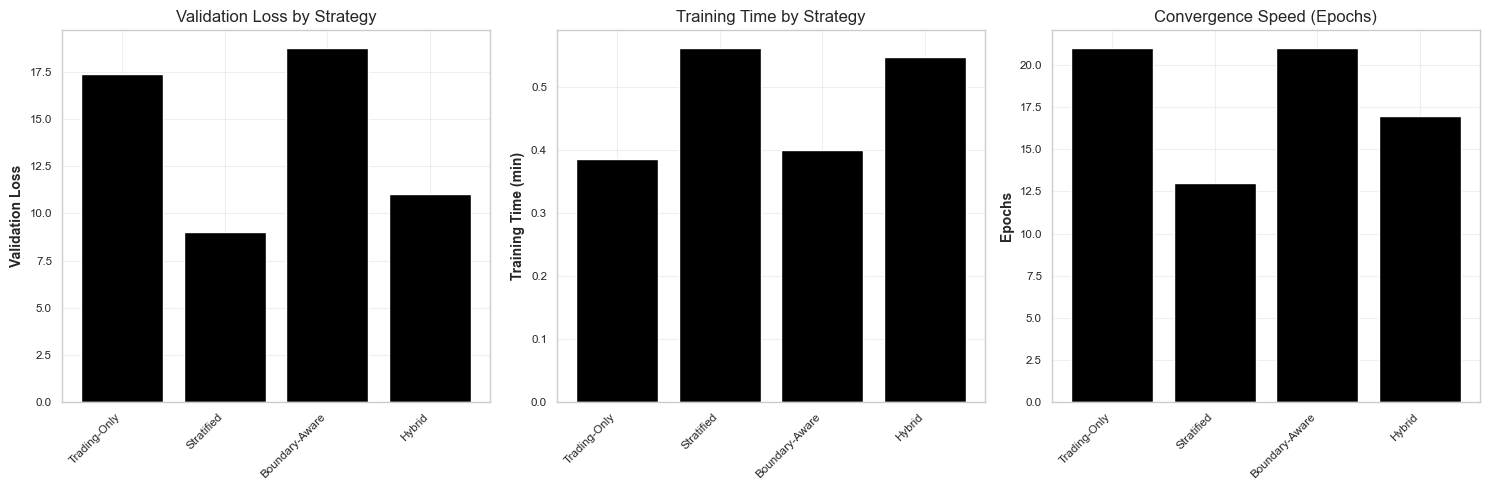


Visualization saved to ..\results\strategy_training_comparison.png


In [8]:
# Create results DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("STRATEGY COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))

# Identify best strategy
if len(results_df[results_df['success']]) > 0:
    successful_results = results_df[results_df['success']]
    best_idx = successful_results['val_loss'].idxmin()
    best_strategy = successful_results.loc[best_idx, 'strategy']
    
    print("\n" + "="*80)
    print("RECOMMENDATION")
    print("="*80)
    print(f"Best Strategy: {best_strategy}")
    print(f"  Validation Loss: {successful_results.loc[best_idx, 'val_loss']:.4f}")
    print(f"  Training Time: {successful_results.loc[best_idx, 'training_time_minutes']:.2f} min")
    print(f"  Epochs: {successful_results.loc[best_idx, 'epochs_trained']}")
    print("\nThis strategy will be used for Chronos training (Phase 3).")
    print("="*80)
    
    # Save recommendation
    recommendation = {
        'best_strategy': best_strategy,
        'val_loss': float(successful_results.loc[best_idx, 'val_loss']),
        'training_time_minutes': float(successful_results.loc[best_idx, 'training_time_minutes']),
        'epochs_trained': int(successful_results.loc[best_idx, 'epochs_trained']),
        'all_results': results
    }
    
    with open(os.path.join(RESULTS_DIR, 'subsampling_recommendation.json'), 'w') as f:
        json.dump(recommendation, f, indent=2)
    
    print(f"\nRecommendation saved to {os.path.join(RESULTS_DIR, 'subsampling_recommendation.json')}")
else:
    print("\n⚠️  No successful training runs!")

# Visualize comparison
if len(results_df[results_df['success']]) > 0:
    successful = results_df[results_df['success']]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Validation loss
    axes[0].bar(range(len(successful)), successful['val_loss'])
    axes[0].set_xticks(range(len(successful)))
    axes[0].set_xticklabels(successful['strategy'], rotation=45, ha='right')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_title('Validation Loss by Strategy')
    axes[0].grid(True, alpha=0.3)
    
    # Training time
    axes[1].bar(range(len(successful)), successful['training_time_minutes'])
    axes[1].set_xticks(range(len(successful)))
    axes[1].set_xticklabels(successful['strategy'], rotation=45, ha='right')
    axes[1].set_ylabel('Training Time (min)')
    axes[1].set_title('Training Time by Strategy')
    axes[1].grid(True, alpha=0.3)
    
    # Epochs trained
    axes[2].bar(range(len(successful)), successful['epochs_trained'])
    axes[2].set_xticks(range(len(successful)))
    axes[2].set_xticklabels(successful['strategy'], rotation=45, ha='right')
    axes[2].set_ylabel('Epochs')
    axes[2].set_title('Convergence Speed (Epochs)')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'strategy_training_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to {os.path.join(RESULTS_DIR, 'strategy_training_comparison.png')}")

## 8. Summary and Next Steps

We have tested 4 different subsampling strategies:

1. **Trading-Only**: Maximum efficiency, may lose some context
2. **Stratified**: Balanced approach with some non-trading data
3. **Boundary-Aware**: Preserves transition context
4. **Hybrid**: Combination of boundary awareness and stratified sampling

The recommended strategy balances:
- Training efficiency (speed and memory)
- Model performance (validation loss)
- Convergence quality (epochs needed)

This strategy will be applied in:
- Phase 2: Baseline model training
- Phase 3: Chronos model training